In [1]:
import time
from os.path import join, dirname, expanduser

import numpy as np
import cv2
import torch
import torch.nn as nn
from torchvision.models import resnet101

from yolort.models.yolo import YOLO
from yolort.utils import Visualizer
from yolort.v5 import load_yolov5_model, non_max_suppression

In [2]:
# configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_cuda = False if str(device) == "cpu" else True

models_bcls = "../weights/pytorch/resnet101_blood_cls.pth"
#models_bdet_th = "../weights/pytorch/yolov5_blood_det_th.pt"
models_bdet_th = "../python/runs/train/exp4/weights/best.pt"
models_bdet_ir = "../weights/pytorch/yolov5_blood_det_ir.pt"
models_bdet = "../weights/pytorch/yolov5s_det_th.pt"
models_fdet = "../weights/pytorch/yolov5_face_det.pt"


In [3]:
# load model parameters
score_thresh = 0.2
nms_thresh = 0.4

In [4]:
# load models
# blood classification
model_bcls = torch.load(models_bcls, map_location=device)


# blood detection
#model_bdet_th = YOLO.load_from_yolov5(models_bdet_th, score_thresh, nms_thresh)
#model_bdet_th = model_bdet_th.eval()
#model_bdet_th = model_bdet_th.to(device)

#model_bdet_ir = YOLO.load_from_yolov5(models_bdet_ir, score_thresh, nms_thresh)
#model_bdet_ir = model_bdet_ir.eval()
#model_bdet_ir = model_bdet_ir.to(device)

model_bdet = YOLO.load_from_yolov5(models_bdet, score_thresh, nms_thresh)
model_bdet = model_bdet.eval()
model_bdet = model_bdet.to(device)

# face detection
model_fdet = YOLO.load_from_yolov5(models_fdet, score_thresh, nms_thresh)
model_fdet = model_fdet.eval()
model_fdet = model_fdet.to(device)

In [5]:
#show class names (need to load original yolo model
yolov5_bdet_th = load_yolov5_model(models_bdet_th, fuse=True)
yolov5_bdet_ir = load_yolov5_model(models_bdet_ir, fuse=True)
yolov5_bdet = load_yolov5_model(models_bdet, fuse=True)
yolov5_fdet = load_yolov5_model(models_fdet, fuse=True)

classes_bdet_th = yolov5_bdet_th.names
classes_bdet_ir = yolov5_bdet_ir.names
classes_bdet = yolov5_bdet.names
classes_fdet = yolov5_fdet.names

print("Classes blood detection - th", classes_bdet_th)
print("Classes blood detection - ir", classes_bdet_ir)
print("Classes blood detection", classes_bdet)
print("Classes face detection", classes_fdet)

Fusing layers... 
Model summary: 157 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
Fusing layers... 
Model Summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Fusing layers... 
Model Summary: 157 layers, 7029004 parameters, 0 gradients, 15.8 GFLOPs
Fusing layers... 
Model Summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs


Classes blood detection - th {0: 'Cold_Background', 1: 'Cold_Body', 2: 'Warm_Background', 3: 'Warm_Body', 4: 'Warm_Dripping'}
Classes blood detection - ir {0: 'Blood_Background', 1: 'Blood_Skin'}
Classes blood detection {0: 'Cold_Background', 1: 'Cold_Body', 2: 'Face', 3: 'Forehead', 4: 'Warm_Background', 5: 'Warm_Body', 6: 'Warm_Dripping'}
Classes face detection {0: 'Face', 1: 'Forehead'}


In [11]:
def sixteen_bits2eight_bits(pixel, max_value):
    # Pseudo colouring the 16 bit images
    pixel = (pixel - np.min(pixel)) / (max_value-np.min(pixel))
    pixel = np.rint(pixel * 255)
    return pixel.astype("uint8")

In [17]:
# input data and transform (using opencv)
HOME = expanduser("~")
#filename = join(HOME, "Datasets/spectronix/thermal/reference/T_IM_182.png")
filename = join(HOME, "Downloads/slack_spectronix/investigate/thermal/16bit/2/fail_00001.png")

img = cv2.imread(filename, cv2.IMREAD_ANYDEPTH) #input

img = sixteen_bits2eight_bits(img, 301000)

img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
img = torch.as_tensor(img.astype("float32").transpose(2,0,1)).to(device)
img /= 255.
img = img.unsqueeze(0)
print(img.dtype)

#img = torch.as_tensor(img.astype("float32").transpose(2,0,1)).to(device)
#img /= 255.
#img = img.unsqueeze(0)

torch.float32


In [15]:
# dry run
for i in range(5):
    #model_bcls(img)
    #model_bdet_th(img)
    #model_bdet_ir(img)
    model_bdet(img)
    model_fdet(img)

RuntimeError: Input type (torch.cuda.ByteTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [8]:
with torch.no_grad(): #ensures autograd is off
    # evaluate classifier
    start = time.time()
    out_bcls = model_bcls(img)
    end = time.time()
    print("Blood classification runtime [ms]: ", 1000*(end-start))

    start = time.time()
    out_bdet = model_bdet(img)
    end = time.time()
    print("Blood detection runtime [ms]: ", 1000*(end-start))

    start = time.time()
    out_fdet = model_fdet(img)
    end = time.time()
    print("Face detection runtime [ms]: ", 1000*(end-start))

Blood classification runtime [ms]:  6.743192672729492
Blood detection runtime [ms]:  3.7796497344970703
Face detection runtime [ms]:  2.341032028198242


In [9]:
print("Output bdet:", out_bdet[0])
print("Output fdet:", out_fdet[0])

Output bdet: {'scores': tensor([], device='cuda:0'), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'boxes': tensor([], device='cuda:0', size=(0, 4))}
Output fdet: {'scores': tensor([], device='cuda:0'), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'boxes': tensor([], device='cuda:0', size=(0, 4))}


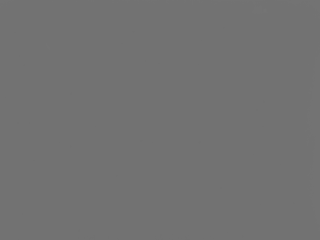

In [10]:
# verify results
img_raw = cv2.imread(filename) #original
v = Visualizer(img_raw, list(classes_bdet.values()))
v.draw_instance_predictions(out_bdet[0])
v.imshow(scale=0.5)

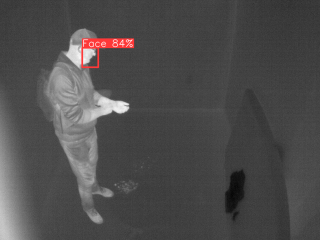

In [14]:
# verify results
img_raw = cv2.imread(filename) #original
v = Visualizer(img_raw, list(classes_fdet.values()))
v.draw_instance_predictions(out_fdet[0])
v.imshow(scale=0.5)